<a href="https://colab.research.google.com/github/Hgherzog/NoisyBatchNorm-YeoJohnsonBatchNorm/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#At the end I can go seperate the different parts into different files

In [ ]:
import torch, math, copy
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


In [ ]:
!pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 121 kB 375 kB/s 
     |████████████████████████████████| 1.6 MB 1.5 MB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 


In [ ]:
from d2l import torch as d2l
def noisy_shift_batch_norm(X, beta, moving_mean, moving_var, eps, momentum):
  """ NoisySSNorm with only shifting and shift noise 
  """
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    #With regularization noise
    epsilon = torch.normal(torch.zeros_like(X), torch.ones_like(X))
    Y =  X_hat + beta * epsilon
    return Y, moving_mean.data, moving_var.data

In [ ]:
class NoisyShiftNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        #beta initialization
        # b_0 = torch.normal(torch.zeros(shape), 0.01 + torch.zeros(shape))
        b_0 = 0.35
        self.beta = nn.Parameter(b_0 + torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = noisy_shift_batch_norm(
            X,  self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
def noisy_scale_batch_norm(X, gamma, noise_scale, moving_mean, moving_var, eps, momentum):
  """ NoisySSNorm with only scale noise and not shift noise
  """
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    #With regularization noise
    epsilon = torch.normal(torch.zeros_like(X), torch.ones_like(X))
    Y =  (gamma+epsilon)*X_hat 
    return Y, moving_mean.data, moving_var.data

In [ ]:
class NoisyScaleNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        #beta initialization
        # b_0 = torch.normal(torch.zeros(shape), 0.01 + torch.zeros(shape))
        g_0 = 0.2
        self.noise_scale = self.beta = nn.Parameter(g_0 + torch.zeros(shape))
        self.gamma = nn.Parameter(g_0 + torch.ones(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = noisy_scale_batch_norm(
            X, self.gamma, self.noise_scale, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
from d2l import torch as d2l
def noisy_SS_batch_norm(X, gamma, beta, noise_scale, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    #With regularization noise for both scale and shift
    epsilon1 = torch.normal(torch.zeros_like(X), torch.ones_like(X))
    epsilon2 = torch.normal(torch.zeros_like(X), torch.ones_like(X))
    Y =  (gamma + noise_scale*epsilon1)*X_hat + beta*epsilon2 #Noise_scale is implicit in beta 2
    return Y, moving_mean.data, moving_var.data

In [ ]:
class NoisySSBatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        #beta initialization
        # b_0 = torch.normal(torch.zeros(shape), 0.01 + torch.zeros(shape))
        g_0 = 0.2
        b_0 = 0.2
        self.noise_scale = self.beta = nn.Parameter(g_0 + torch.zeros(shape))
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(b_0 + torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = noisy_SS_batch_norm(
            X, self.gamma, self.beta, self.noise_scale, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
def mean_batch_norm2(X,beta, moving_mean, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
    Y =  X_hat + beta #Shift only
    return Y, moving_mean.data

In [ ]:
class MeanNorm2(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        #beta initialization
        # b_0 = torch.normal(torch.zeros(shape), 0.01 + torch.zeros(shape))
        b_0 = 0
        self.beta = nn.Parameter(b_0 + torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, = mean_batch_norm2(X, self.beta, self.moving_mean,
                                                momentum=0.1)
        return Y

In [ ]:
def var_batch_norm2(X, gamma, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = X / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = X  / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y =  gamma*X_hat  #Shift only
    return Y, moving_var.data

In [ ]:
class VarNorm2(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        #beta initialization
        # b_0 = torch.normal(torch.zeros(shape), 0.01 + torch.zeros(shape))
        g_0 = 0
        self.gamma = nn.Parameter(g_0 +torch.ones(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_var.device != X.device:
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_var = var_batch_norm2(
            X, self.gamma, self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
def no_scale_no_shift_batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y =  X_hat  #No Scale or Shift
    return Y, moving_mean.data, moving_var.data

In [ ]:
class SS_noneBatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = no_scale_no_shift_batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y =  gamma*X_hat + beta #Scale and Shift
    return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully connected layer and 4 for a convolutional layer
    #Does batch norm with data normalized to a log normal distribution
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [ ]:
#Load dataset
bs = 256
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_dataset = datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = datasets.CIFAR10("data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), normalize
]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

#Device Settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_dataset = datasets.CIFAR10("data", train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ]))
train_indices = list(range(1, 2001))
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=bs, shuffle=True)

test_dataset = datasets.CIFAR10("data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), normalize
]))
test_indices = list(range(1, 401))
test_subset = torch.utils.data.Subset(test_dataset, test_indices)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Train.ipynb code 
def train(epochs, model, criterion, optimizer, train_loader, test_loader):
    epochs_and_test_err = []
    for epoch in range(epochs):
        train_err = train_epoch(model, criterion, optimizer, train_loader)
        test_err = test(model, test_loader)
        epochs_and_test_err.append((epoch, test_err))
        print('Epoch {:03d}/{:03d}, Train Error {:.2f}% || Test Error {:.2f}%'.format(epoch, epochs, train_err*100, test_err*100))
    return train_err, test_err, epochs_and_test_err
    
def train_epoch(model, criterion, optimizer, loader):
    total_correct = 0.
    total_samples = 0.
    
    for batch_idx, (data, target) in enumerate(loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        len_t = len(target)
        output = model(data)
        loss = criterion(output, target)

        for i in range(len_t):
          
          total_correct +=  1 if torch.argmax(output[i]) == target[i] else 0
          total_samples += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return 1 - total_correct/total_samples

In [ ]:
#Test.ipynb code
def test(model, loader):
  total_correct = 0.
  total_samples = 0.
  model.eval()
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(loader):
      if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
      output = model(data)

      for i, val in enumerate(target):
        total_correct += 1 if torch.argmax(output[i]) == val else 0
        total_samples += 1 

  return 1 - total_correct/total_samples

In [ ]:
#ResNet Models from https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py 
#Generic norm implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

#Do I need () or not
bn_dict = {'control' : BatchNorm, 'noisyshift': NoisyShiftNorm,'noisyscale': NoisyScaleNorm ,'noisyss': NoisySSBatchNorm, 'noisyss2' : NoisySSBatchNorm2,
'meannorm2' : MeanNorm2, 'varnorm2': VarNorm2, 'ss_none' : SS_noneBatchNorm } 


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, bn_type, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = bn_dict[bn_type](planes, 4)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = bn_dict[bn_type](planes, 4)

        self.shortcut = nn.Sequential()
        #TO_DO: make it only usable for CIFAR10
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, bn_type, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = bn_dict[bn_type](16, 4)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], bn_type, stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], bn_type, stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], bn_type, stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, bn_type, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, bn_type, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet20(bn_type):
    return ResNet(BasicBlock, [3, 3, 3], bn_type)


def resnet32(bn_type):
    return ResNet(BasicBlock, [5, 5, 5], bn_type)


def resnet44(bn_type):
    return ResNet(BasicBlock, [7, 7, 7], bn_type)


def resnet56(bn_type):
    return ResNet(BasicBlock, [9, 9, 9], bn_type)


def resnet110(bn_type):
    return ResNet(BasicBlock, [18, 18, 18], bn_type)


def resnet1202(bn_type):
    return ResNet(BasicBlock, [200, 200, 200], bn_type)

#Number of parameters and layer testing
# def test_net(net):
#     import numpy as np
#     total_params = 0

#     for x in filter(lambda p: p.requires_grad, net.parameters()):
#         total_params += np.prod(x.data.numpy().shape)
#     print("Total number of params", total_params)
#     print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


# if __name__ == "__main__":
#     for net_name in __all__:
#         if net_name.startswith('resnet'):
#             print(net_name)
#             test_net(globals()[net_name]())
#             print()

# Experiments

In [ ]:
#Hyper Parameters need to think about tuning budget for these and how I will go about finding optimal LR for each
lr = 0.01
momentum = 0.9 
epochs = 25
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
#Experimments

#We want to Run Each different norm on 22, 32, 56, 110 resnets first and observe test accuracy over 25 epochs against control

#Control first 
# for each of the norms with a noise
# we will adjust the scale and shift parameters by seeing how it performs over 10 epochs
#We will then run the full tests with the best seeing parameters at 25 epochs

#Code for Generating graph of test accuracy over training epochs
import matplotlib.pyplot as plt
def plot_epochs_and_accuracies(e_and_acc, plot_title):
  x, y = zip(*e_and_acc)
  fig1 = plt.plot(*zip(*e_and_acc))
  plt.xlabel('Number of Epochs')
  plt.ylabel('Test Accuracy')
  plt.title(plot_title)
  plt.show()

In [ ]:
 {'control' : nn.BatchNorm2d, 'noisyshift': NoisyShiftNorm,'noisyscale': NoisyScaleNorm ,'noisyss': NoisySSBatchNorm,
'noisymean': NoisyMeanBatchNorm, 'noisyvar' : NoisyVarBatchNorm, 'meannorm1' : MeanNorm1, 
'meannorm2' : MeanNorm2, 'varnorm1': VarNorm1, 'varnorm2': VarNorm2, 'ss_none ' : SS_noneBatchNorm , 'ss_only': SS_onlyBatchNorm}

In [ ]:
model = ResNet(BasicBlock, [1, 1, 1], 'control' ).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(30, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/030, Train Error 86.95% || Test Error 87.50%
Epoch 001/030, Train Error 80.95% || Test Error 83.50%
Epoch 002/030, Train Error 77.95% || Test Error 79.25%
Epoch 003/030, Train Error 72.55% || Test Error 78.00%
Epoch 004/030, Train Error 69.20% || Test Error 74.75%
Epoch 005/030, Train Error 68.50% || Test Error 73.50%
Epoch 006/030, Train Error 66.60% || Test Error 73.50%
Epoch 007/030, Train Error 65.20% || Test Error 68.75%
Epoch 008/030, Train Error 63.10% || Test Error 68.00%
Epoch 009/030, Train Error 62.65% || Test Error 65.75%
Epoch 010/030, Train Error 61.30% || Test Error 66.75%
Epoch 011/030, Train Error 60.00% || Test Error 65.00%
Epoch 012/030, Train Error 59.05% || Test Error 65.00%
Epoch 013/030, Train Error 59.60% || Test Error 66.25%
Epoch 014/030, Train Error 59.30% || Test Error 63.75%
Epoch 015/030, Train Error 57.90% || Test Error 62.50%
Epoch 016/030, Train Error 56.35% || Test Error 62.25%
Epoch 017/030, Train Error 56.45% || Test Error 62.25%
Epoch 018/

SS None Resnet22
Epoch 000/015, Train Error 62.12% || Test Error 54.10%
Epoch 001/015, Train Error 47.39% || Test Error 43.44%
Epoch 002/015, Train Error 40.48% || Test Error 41.10%
Epoch 003/015, Train Error 35.58% || Test Error 38.13%
Epoch 004/015, Train Error 31.28% || Test Error 37.89%
Epoch 005/015, Train Error 27.92% || Test Error 33.58%
Epoch 006/015, Train Error 25.18% || Test Error 35.17%
Epoch 007/015, Train Error 22.56% || Test Error 33.51%
Epoch 008/015, Train Error 19.80% || Test Error 35.45%
Epoch 009/015, Train Error 17.19% || Test Error 32.38%
Epoch 010/015, Train Error 15.15% || Test Error 37.72%
Epoch 011/015, Train Error 13.28% || Test Error 41.75%
Epoch 012/015, Train Error 11.61% || Test Error 37.23%
Epoch 013/015, Train Error 9.72% || Test Error 35.23%
Epoch 014/015, Train Error 8.83% || Test Error 33.30%


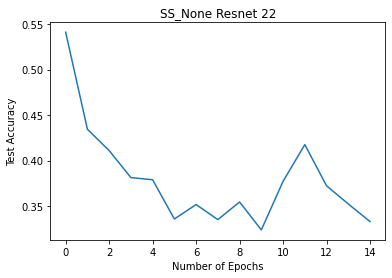

In [ ]:
# SS nonw ResNet 22 with beta 0 and noise scale equal 0.2
print("SS None Resnet22")
model = ResNet(BasicBlock, [9, 9, 9], 'ss_none').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(15, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'SS_None Resnet 22')

NoisySSNorm2 Resnet22
Epoch 000/025, Train Error 65.60% || Test Error 57.17%
Epoch 001/025, Train Error 51.99% || Test Error 51.65%
Epoch 002/025, Train Error 45.70% || Test Error 47.37%
Epoch 003/025, Train Error 41.69% || Test Error 41.28%
Epoch 004/025, Train Error 37.49% || Test Error 39.83%
Epoch 005/025, Train Error 34.59% || Test Error 39.99%
Epoch 006/025, Train Error 32.01% || Test Error 33.22%
Epoch 007/025, Train Error 29.76% || Test Error 34.36%
Epoch 008/025, Train Error 27.84% || Test Error 31.32%
Epoch 009/025, Train Error 26.37% || Test Error 32.04%
Epoch 010/025, Train Error 24.65% || Test Error 33.33%
Epoch 011/025, Train Error 23.36% || Test Error 29.61%
Epoch 012/025, Train Error 21.96% || Test Error 25.60%
Epoch 013/025, Train Error 20.48% || Test Error 27.07%
Epoch 014/025, Train Error 19.39% || Test Error 29.89%
Epoch 015/025, Train Error 18.06% || Test Error 29.28%
Epoch 016/025, Train Error 16.92% || Test Error 27.19%
Epoch 017/025, Train Error 15.82% || Test E

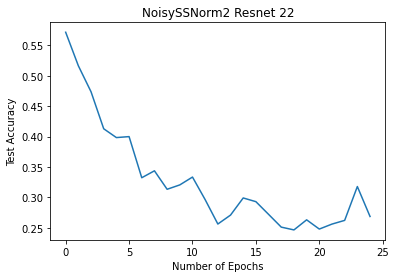

In [ ]:
#NoisySSNorm2 ResNet 22 with beta 0 and noise scale equal 0.2
print("NoisySSNorm2 Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyss2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'NoisySSNorm2 Resnet 22')

NoisySSNorm2 Resnet22
Epoch 000/025, Train Error 66.26% || Test Error 59.72%
Epoch 001/025, Train Error 52.41% || Test Error 56.99%
Epoch 002/025, Train Error 45.14% || Test Error 45.04%
Epoch 003/025, Train Error 39.83% || Test Error 39.27%
Epoch 004/025, Train Error 35.86% || Test Error 37.20%
Epoch 005/025, Train Error 33.55% || Test Error 36.34%
Epoch 006/025, Train Error 31.09% || Test Error 37.47%
Epoch 007/025, Train Error 29.17% || Test Error 34.42%
Epoch 008/025, Train Error 27.11% || Test Error 31.85%
Epoch 009/025, Train Error 25.77% || Test Error 29.01%
Epoch 010/025, Train Error 23.99% || Test Error 32.33%
Epoch 011/025, Train Error 22.70% || Test Error 28.84%
Epoch 012/025, Train Error 21.45% || Test Error 27.61%
Epoch 013/025, Train Error 20.05% || Test Error 28.20%
Epoch 014/025, Train Error 18.94% || Test Error 23.94%
Epoch 015/025, Train Error 17.80% || Test Error 24.47%
Epoch 016/025, Train Error 16.56% || Test Error 26.20%
Epoch 017/025, Train Error 15.63% || Test E

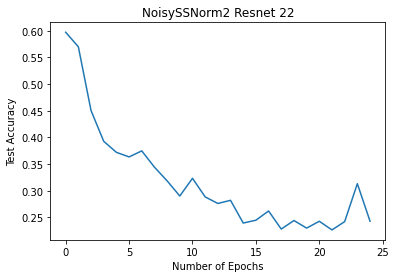

In [ ]:
#NoisySSNorm2 ResNet 22 with beta and noise scale equal zero
print("NoisySSNorm2 Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyss2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'NoisySSNorm2 Resnet 22')

NoisySSNorm2 Resnet22
Epoch 000/025, Train Error 65.58% || Test Error 57.04%
Epoch 001/025, Train Error 50.90% || Test Error 52.19%
Epoch 002/025, Train Error 43.32% || Test Error 44.44%
Epoch 003/025, Train Error 38.68% || Test Error 39.03%
Epoch 004/025, Train Error 35.21% || Test Error 36.89%
Epoch 005/025, Train Error 32.93% || Test Error 37.92%
Epoch 006/025, Train Error 30.53% || Test Error 33.56%
Epoch 007/025, Train Error 28.97% || Test Error 32.51%
Epoch 008/025, Train Error 27.38% || Test Error 32.36%
Epoch 009/025, Train Error 25.77% || Test Error 32.01%
Epoch 010/025, Train Error 24.50% || Test Error 28.10%
Epoch 011/025, Train Error 23.19% || Test Error 27.98%
Epoch 012/025, Train Error 21.76% || Test Error 26.39%
Epoch 013/025, Train Error 20.73% || Test Error 35.16%
Epoch 014/025, Train Error 19.69% || Test Error 30.05%
Epoch 015/025, Train Error 18.82% || Test Error 26.99%
Epoch 016/025, Train Error 17.66% || Test Error 26.46%
Epoch 017/025, Train Error 16.28% || Test E

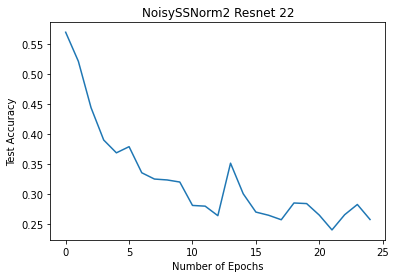

In [ ]:
#NoisySSNorm2 ResNet 22 with beta =0
print("NoisySSNorm2 Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyss2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'NoisySSNorm2 Resnet 22')

NoisySSNorm2 Resnet22
Epoch 000/025, Train Error 66.31% || Test Error 56.10%
Epoch 001/025, Train Error 53.50% || Test Error 52.67%
Epoch 002/025, Train Error 47.01% || Test Error 45.14%
Epoch 003/025, Train Error 41.55% || Test Error 41.81%
Epoch 004/025, Train Error 38.32% || Test Error 37.50%
Epoch 005/025, Train Error 35.07% || Test Error 36.88%
Epoch 006/025, Train Error 32.82% || Test Error 33.49%
Epoch 007/025, Train Error 30.76% || Test Error 34.48%
Epoch 008/025, Train Error 29.01% || Test Error 33.08%
Epoch 009/025, Train Error 27.65% || Test Error 32.52%
Epoch 010/025, Train Error 25.93% || Test Error 31.55%
Epoch 011/025, Train Error 24.59% || Test Error 28.74%
Epoch 012/025, Train Error 23.14% || Test Error 29.13%
Epoch 013/025, Train Error 22.14% || Test Error 28.31%
Epoch 014/025, Train Error 20.72% || Test Error 27.96%
Epoch 015/025, Train Error 19.81% || Test Error 28.41%
Epoch 016/025, Train Error 18.60% || Test Error 26.33%
Epoch 017/025, Train Error 17.10% || Test E

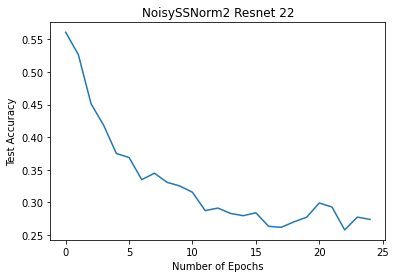

In [ ]:
#NoisySSNorm2 ResNet 22
print("NoisySSNorm2 Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyss2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'NoisySSNorm2 Resnet 22')

In [ ]:
#NoisySSNorm2 ResNet 56
print("NoisySSNorm2 Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'noisyss2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nss56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nss56, 'NoisySSNorm2 Resnet 22')

NoisySSNorm2 Resnet56
Epoch 000/025, Train Error 67.30% || Test Error 60.96%
Epoch 001/025, Train Error 54.03% || Test Error 51.74%
Epoch 002/025, Train Error 47.24% || Test Error 47.73%
Epoch 003/025, Train Error 41.94% || Test Error 46.48%
Epoch 004/025, Train Error 37.78% || Test Error 39.26%
Epoch 005/025, Train Error 34.59% || Test Error 34.31%
Epoch 006/025, Train Error 32.05% || Test Error 33.94%
Epoch 007/025, Train Error 29.71% || Test Error 34.54%
Epoch 008/025, Train Error 27.14% || Test Error 31.56%
Epoch 009/025, Train Error 25.21% || Test Error 28.89%
Epoch 010/025, Train Error 23.92% || Test Error 28.52%
Epoch 011/025, Train Error 22.45% || Test Error 30.17%
Epoch 012/025, Train Error 20.78% || Test Error 27.44%
Epoch 013/025, Train Error 19.82% || Test Error 30.48%
Epoch 014/025, Train Error 18.38% || Test Error 24.55%
Epoch 015/025, Train Error 17.66% || Test Error 24.72%
Epoch 016/025, Train Error 16.69% || Test Error 27.47%
Epoch 017/025, Train Error 15.95% || Test E

NameError: ignored

Control Resnet22
Epoch 000/025, Train Error 61.85% || Test Error 55.07%
Epoch 001/025, Train Error 46.71% || Test Error 48.82%
Epoch 002/025, Train Error 39.84% || Test Error 42.95%
Epoch 003/025, Train Error 35.37% || Test Error 42.06%
Epoch 004/025, Train Error 32.13% || Test Error 34.58%
Epoch 005/025, Train Error 29.30% || Test Error 32.23%
Epoch 006/025, Train Error 26.81% || Test Error 34.91%
Epoch 007/025, Train Error 24.59% || Test Error 31.85%
Epoch 008/025, Train Error 22.80% || Test Error 30.96%
Epoch 009/025, Train Error 21.23% || Test Error 31.25%
Epoch 010/025, Train Error 19.24% || Test Error 28.33%
Epoch 011/025, Train Error 17.89% || Test Error 28.11%
Epoch 012/025, Train Error 16.25% || Test Error 29.68%
Epoch 013/025, Train Error 15.17% || Test Error 33.50%
Epoch 014/025, Train Error 13.84% || Test Error 29.71%
Epoch 015/025, Train Error 12.58% || Test Error 30.52%
Epoch 016/025, Train Error 11.02% || Test Error 30.93%
Epoch 017/025, Train Error 10.17% || Test Error 

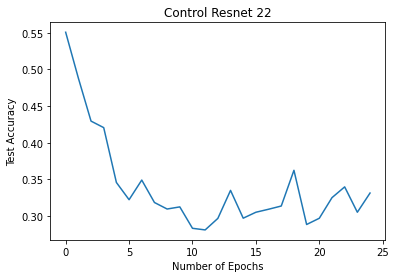

In [ ]:
#Control ResNet 22
print("Control Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'control').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'Control Resnet 22')

Control Resnet56
Epoch 000/025, Train Error 63.25% || Test Error 52.59%
Epoch 001/025, Train Error 47.44% || Test Error 46.25%
Epoch 002/025, Train Error 40.55% || Test Error 40.38%
Epoch 003/025, Train Error 35.36% || Test Error 40.07%
Epoch 004/025, Train Error 31.29% || Test Error 33.52%
Epoch 005/025, Train Error 27.79% || Test Error 35.16%
Epoch 006/025, Train Error 25.24% || Test Error 30.52%
Epoch 007/025, Train Error 21.85% || Test Error 35.65%
Epoch 008/025, Train Error 19.95% || Test Error 33.42%
Epoch 009/025, Train Error 17.07% || Test Error 37.21%
Epoch 010/025, Train Error 15.08% || Test Error 42.65%
Epoch 011/025, Train Error 13.09% || Test Error 34.96%
Epoch 012/025, Train Error 11.57% || Test Error 33.82%
Epoch 013/025, Train Error 9.57% || Test Error 33.17%
Epoch 014/025, Train Error 7.89% || Test Error 33.71%
Epoch 015/025, Train Error 6.93% || Test Error 32.61%
Epoch 016/025, Train Error 6.28% || Test Error 35.31%
Epoch 017/025, Train Error 4.94% || Test Error 32.68

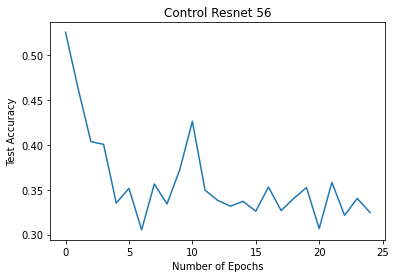

In [ ]:
#Control ResNet 56
print("Control Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'control').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_control56, 'Control Resnet 56')

Noisy Shift Resnet22
Epoch 000/025, Train Error 66.70% || Test Error 60.78%
Epoch 001/025, Train Error 54.28% || Test Error 50.57%
Epoch 002/025, Train Error 48.06% || Test Error 49.53%
Epoch 003/025, Train Error 42.91% || Test Error 42.23%
Epoch 004/025, Train Error 39.12% || Test Error 39.87%
Epoch 005/025, Train Error 35.93% || Test Error 39.10%
Epoch 006/025, Train Error 33.34% || Test Error 39.12%
Epoch 007/025, Train Error 31.53% || Test Error 37.68%
Epoch 008/025, Train Error 29.79% || Test Error 33.73%
Epoch 009/025, Train Error 28.27% || Test Error 30.76%
Epoch 010/025, Train Error 27.09% || Test Error 32.39%
Epoch 011/025, Train Error 25.69% || Test Error 29.74%
Epoch 012/025, Train Error 24.51% || Test Error 31.60%
Epoch 013/025, Train Error 23.13% || Test Error 27.65%
Epoch 014/025, Train Error 22.15% || Test Error 26.77%
Epoch 015/025, Train Error 21.08% || Test Error 26.02%
Epoch 016/025, Train Error 20.01% || Test Error 26.93%
Epoch 017/025, Train Error 18.94% || Test Er

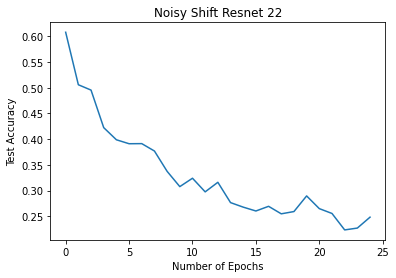

In [ ]:
#Noisy shift 22 beta=0.35 motivate this choice with more experiments
print("Noisy Shift Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyshift').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_control22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)
#mistakenly didnt change the names of the list
plot_epochs_and_accuracies(epochs_and_test_errs_control22, 'Noisy Shift Resnet 22')

Noisy Shift Resnet56
Epoch 000/025, Train Error 68.28% || Test Error 60.95%
Epoch 001/025, Train Error 54.38% || Test Error 51.51%
Epoch 002/025, Train Error 48.32% || Test Error 46.05%
Epoch 003/025, Train Error 43.63% || Test Error 49.51%
Epoch 004/025, Train Error 38.79% || Test Error 39.31%
Epoch 005/025, Train Error 35.86% || Test Error 38.09%
Epoch 006/025, Train Error 33.22% || Test Error 33.76%
Epoch 007/025, Train Error 31.17% || Test Error 38.68%
Epoch 008/025, Train Error 29.13% || Test Error 32.61%
Epoch 009/025, Train Error 27.40% || Test Error 34.12%
Epoch 010/025, Train Error 26.55% || Test Error 36.89%
Epoch 011/025, Train Error 24.92% || Test Error 32.00%
Epoch 012/025, Train Error 23.45% || Test Error 29.65%
Epoch 013/025, Train Error 22.56% || Test Error 26.80%
Epoch 014/025, Train Error 21.34% || Test Error 25.44%
Epoch 015/025, Train Error 20.30% || Test Error 26.03%
Epoch 016/025, Train Error 19.18% || Test Error 25.82%
Epoch 017/025, Train Error 18.23% || Test Er

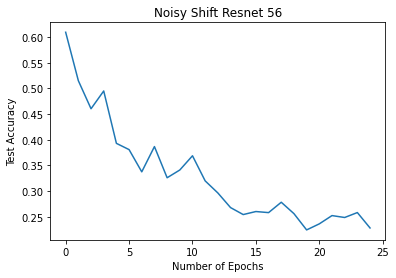

In [ ]:
#Noisy shift 56 beta=0.35 maybe try again wiht higher beta
print("Noisy Shift Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'noisyshift').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nshift56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nshift56, 'Noisy Shift Resnet 56')

In [ ]:
#Noisy Scale 22
print("Noisy Scale Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyscale').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nscale22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nscale22, 'Noisy Scale Resnet 22')

Noisy Scale Resnet22
Epoch 000/025, Train Error 82.11% || Test Error 73.92%
Epoch 001/025, Train Error 70.86% || Test Error 66.32%
Epoch 002/025, Train Error 64.67% || Test Error 60.95%
Epoch 003/025, Train Error 59.80% || Test Error 59.57%
Epoch 004/025, Train Error 57.42% || Test Error 56.13%
Epoch 005/025, Train Error 55.53% || Test Error 57.18%
Epoch 006/025, Train Error 53.49% || Test Error 50.00%
Epoch 007/025, Train Error 50.91% || Test Error 50.49%
Epoch 008/025, Train Error 48.35% || Test Error 48.44%
Epoch 009/025, Train Error 45.69% || Test Error 45.26%
Epoch 010/025, Train Error 43.81% || Test Error 41.63%
Epoch 011/025, Train Error 41.91% || Test Error 43.21%
Epoch 012/025, Train Error 40.13% || Test Error 39.04%
Epoch 013/025, Train Error 39.17% || Test Error 41.05%
Epoch 014/025, Train Error 37.92% || Test Error 38.25%
Epoch 015/025, Train Error 36.88% || Test Error 40.22%


KeyboardInterrupt: ignored

In [ ]:
#Noisy Scale 56 just an ablation seemed to tjust rain slower wait on this
print("Noisy Scale Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'noisyscale').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nscale56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nscale56, 'Noisy Scale Resnet 56')

Noisy Scale Resnet56
Epoch 000/025, Train Error 78.68% || Test Error 73.74%
Epoch 001/025, Train Error 70.27% || Test Error 69.10%
Epoch 002/025, Train Error 65.21% || Test Error 63.69%
Epoch 003/025, Train Error 61.80% || Test Error 60.63%
Epoch 004/025, Train Error 59.51% || Test Error 57.09%
Epoch 005/025, Train Error 57.25% || Test Error 57.04%
Epoch 006/025, Train Error 55.12% || Test Error 56.21%
Epoch 007/025, Train Error 54.24% || Test Error 52.07%
Epoch 008/025, Train Error 52.72% || Test Error 51.25%
Epoch 009/025, Train Error 51.06% || Test Error 49.49%
Epoch 010/025, Train Error 49.62% || Test Error 49.56%
Epoch 011/025, Train Error 48.51% || Test Error 47.50%
Epoch 012/025, Train Error 46.52% || Test Error 48.70%
Epoch 013/025, Train Error 46.21% || Test Error 45.02%
Epoch 014/025, Train Error 44.87% || Test Error 44.68%
Epoch 015/025, Train Error 43.62% || Test Error 42.35%
Epoch 016/025, Train Error 42.60% || Test Error 42.73%
Epoch 017/025, Train Error 42.46% || Test Er

KeyboardInterrupt: ignored

Noisy Scale and Shift Resnet22
Epoch 000/025, Train Error 65.75% || Test Error 57.72%
Epoch 001/025, Train Error 52.36% || Test Error 48.83%
Epoch 002/025, Train Error 46.36% || Test Error 46.46%
Epoch 003/025, Train Error 40.88% || Test Error 42.36%
Epoch 004/025, Train Error 37.14% || Test Error 43.52%
Epoch 005/025, Train Error 34.35% || Test Error 37.23%
Epoch 006/025, Train Error 31.86% || Test Error 38.37%
Epoch 007/025, Train Error 29.52% || Test Error 34.01%
Epoch 008/025, Train Error 27.84% || Test Error 35.54%
Epoch 009/025, Train Error 25.92% || Test Error 31.53%
Epoch 010/025, Train Error 24.58% || Test Error 27.84%
Epoch 011/025, Train Error 23.02% || Test Error 31.94%
Epoch 012/025, Train Error 21.59% || Test Error 31.18%
Epoch 013/025, Train Error 20.62% || Test Error 26.82%
Epoch 014/025, Train Error 19.37% || Test Error 27.65%
Epoch 015/025, Train Error 18.11% || Test Error 26.84%
Epoch 016/025, Train Error 17.14% || Test Error 28.45%
Epoch 017/025, Train Error 15.74% 

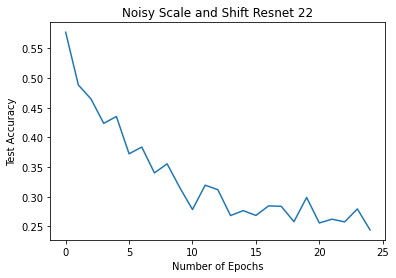

In [ ]:
#Noisy SS Batch Norm 22 beta too small to prevent overfitting need bigger beta
print("Noisy Scale and Shift Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisyss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nss22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nss22, 'Noisy Scale and Shift Resnet 22')

In [ ]:
#Noisy SS 56 have this as an ablation if its interesting
print("Noisy Scale and Shift Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'noisyss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_nss56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_nss56, 'Noisy Scale and Shift Resnet 56')

NoisyNorm Resnet22
Epoch 000/025, Train Error 61.16% || Test Error 51.80%
Epoch 001/025, Train Error 46.77% || Test Error 44.31%
Epoch 002/025, Train Error 40.61% || Test Error 47.67%
Epoch 003/025, Train Error 35.67% || Test Error 40.45%
Epoch 004/025, Train Error 32.16% || Test Error 34.90%
Epoch 005/025, Train Error 29.55% || Test Error 32.02%
Epoch 006/025, Train Error 27.06% || Test Error 33.79%
Epoch 007/025, Train Error 24.68% || Test Error 30.60%
Epoch 008/025, Train Error 22.81% || Test Error 29.78%
Epoch 009/025, Train Error 21.01% || Test Error 30.11%
Epoch 010/025, Train Error 19.44% || Test Error 28.02%
Epoch 011/025, Train Error 17.96% || Test Error 28.27%
Epoch 012/025, Train Error 16.29% || Test Error 27.73%
Epoch 013/025, Train Error 15.07% || Test Error 29.81%
Epoch 014/025, Train Error 13.56% || Test Error 32.80%
Epoch 015/025, Train Error 12.63% || Test Error 28.18%
Epoch 016/025, Train Error 11.06% || Test Error 28.12%
Epoch 017/025, Train Error 9.78% || Test Error

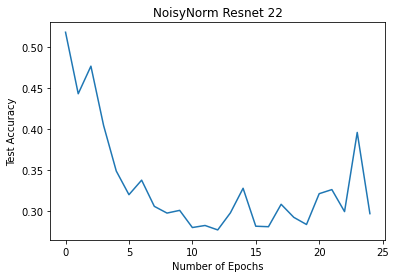

In [ ]:
#Noisy norm 22
print("NoisyNorm Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'noisy').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_noisy22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_noisy22, 'NoisyNorm Resnet 22')



NoisyNorm Resnet56
Epoch 000/025, Train Error 62.87% || Test Error 55.71%
Epoch 001/025, Train Error 47.84% || Test Error 47.39%
Epoch 002/025, Train Error 40.41% || Test Error 39.53%
Epoch 003/025, Train Error 35.55% || Test Error 38.23%
Epoch 004/025, Train Error 31.63% || Test Error 34.45%
Epoch 005/025, Train Error 28.39% || Test Error 38.58%
Epoch 006/025, Train Error 25.26% || Test Error 35.03%
Epoch 007/025, Train Error 22.81% || Test Error 35.82%
Epoch 008/025, Train Error 20.61% || Test Error 32.93%
Epoch 009/025, Train Error 17.92% || Test Error 33.16%
Epoch 010/025, Train Error 16.34% || Test Error 30.88%
Epoch 011/025, Train Error 13.78% || Test Error 39.37%
Epoch 012/025, Train Error 12.26% || Test Error 33.99%
Epoch 013/025, Train Error 10.76% || Test Error 34.84%
Epoch 014/025, Train Error 8.64% || Test Error 36.59%
Epoch 015/025, Train Error 7.47% || Test Error 32.26%
Epoch 016/025, Train Error 6.06% || Test Error 35.89%
Epoch 017/025, Train Error 5.88% || Test Error 29

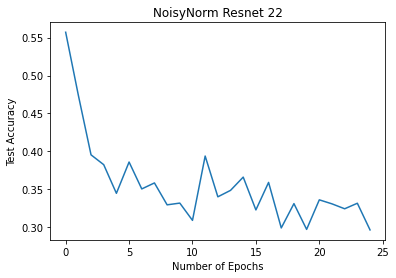

In [ ]:
#Noisy norm 56
print("NoisyNorm Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'noisy').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_noisy56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_noisy56, 'NoisyNorm Resnet 22')



In [ ]:
#Noisy norm 2 where we add noise to the scale term as well maybe higher maybe also to shift Noisy Norm 2

MeanNorm Resnet22
Epoch 000/025, Train Error 66.62% || Test Error 55.79%
Epoch 001/025, Train Error 49.05% || Test Error 44.81%
Epoch 002/025, Train Error 40.53% || Test Error 43.24%
Epoch 003/025, Train Error 35.53% || Test Error 36.15%
Epoch 004/025, Train Error 31.39% || Test Error 32.63%
Epoch 005/025, Train Error 28.23% || Test Error 32.10%
Epoch 006/025, Train Error 25.74% || Test Error 33.10%
Epoch 007/025, Train Error 23.68% || Test Error 30.31%
Epoch 008/025, Train Error 21.52% || Test Error 32.65%
Epoch 009/025, Train Error 19.95% || Test Error 27.58%
Epoch 010/025, Train Error 18.08% || Test Error 29.52%
Epoch 011/025, Train Error 16.92% || Test Error 28.92%
Epoch 012/025, Train Error 15.46% || Test Error 30.31%
Epoch 013/025, Train Error 15.12% || Test Error 32.29%
Epoch 014/025, Train Error 13.96% || Test Error 29.54%
Epoch 015/025, Train Error 12.44% || Test Error 31.26%
Epoch 016/025, Train Error 11.88% || Test Error 26.32%
Epoch 017/025, Train Error 11.46% || Test Error

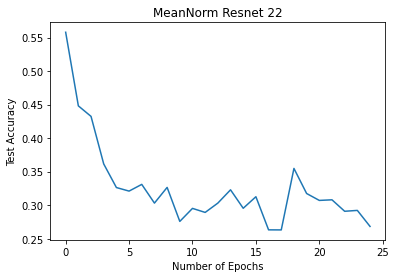

In [ ]:
#Meannorm2 22
print("MeanNorm Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'meannorm2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_m2_22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_m2_22, 'MeanNorm Resnet 22')

In [ ]:
#Meannorm2 56
print("MeanNorm Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'meannorm2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_m2_22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_m2_22, 'MeanNorm Resnet 56')

VarNorm Resnet22
Epoch 000/025, Train Error 72.48% || Test Error 70.00%
Epoch 001/025, Train Error 60.00% || Test Error 56.32%
Epoch 002/025, Train Error 53.72% || Test Error 66.86%
Epoch 003/025, Train Error 49.35% || Test Error 56.99%
Epoch 004/025, Train Error 44.49% || Test Error 54.22%
Epoch 005/025, Train Error 41.09% || Test Error 45.02%
Epoch 006/025, Train Error 38.42% || Test Error 49.39%
Epoch 007/025, Train Error 36.19% || Test Error 45.47%
Epoch 008/025, Train Error 34.46% || Test Error 52.38%
Epoch 009/025, Train Error 32.83% || Test Error 43.42%
Epoch 010/025, Train Error 31.22% || Test Error 44.31%
Epoch 011/025, Train Error 29.51% || Test Error 44.83%
Epoch 012/025, Train Error 28.35% || Test Error 45.82%
Epoch 013/025, Train Error 27.17% || Test Error 33.85%
Epoch 014/025, Train Error 25.96% || Test Error 37.92%
Epoch 015/025, Train Error 24.44% || Test Error 44.72%
Epoch 016/025, Train Error 23.65% || Test Error 37.17%
Epoch 017/025, Train Error 22.92% || Test Error 

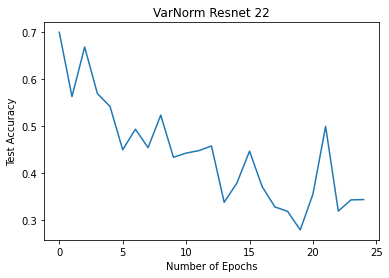

In [ ]:
#varnorm2 22
print("VarNorm Resnet22")
model = ResNet(BasicBlock, [3, 3, 3], 'varnorm2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_var_22 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_var_22, 'VarNorm Resnet 22')

In [ ]:
#varnorm2 56
print("VarNorm Resnet56")
model = ResNet(BasicBlock, [9, 9, 9], 'varnorm2').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs_noisy56 = train(epochs, model, criterion, optimizer, train_loader, test_loader)

plot_epochs_and_accuracies(epochs_and_test_errs_noisy56, 'VarNorm Resnet 56')

In [ ]:
#SS_none batch norm  will need this after
epochs =10 


In [ ]:
#SS_ only is just a simple linear layer

In [ ]:
#These are ablations of noisy norm

In [ ]:
#Noisy Mean batch norm 22

In [ ]:
#Noisy Mean batch norm 56

In [ ]:
#Noisy var batch norm 22

In [ ]:
#Noisy var batch norm 56

In [ ]:
#SS_only

In [ ]:
#Variance and norm ablations

In [ ]:
 {'control' : nn.BatchNorm2d, 'noisyshift': NoisyShiftNorm,'noisyscale': NoisyScaleNorm ,'noisyss': NoisySSBatchNorm,
'noisymean': NoisyMeanBatchNorm, 'noisyvar' : NoisyVarBatchNorm, 'meannorm1' : MeanNorm1, 
'meannorm2' : MeanNorm2, 'varnorm1': VarNorm1, 'varnorm2': VarNorm2, 'ss_none ' : SS_noneBatchNorm , 'ss_only': SS_onlyBatchNorm}

In [ ]:
#Gauss beta=0.4
model = ResNet(BasicBlock, [7, 7, 7], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 71.21% || Test Error 62.08%
Epoch 001/015, Train Error 57.61% || Test Error 55.10%
Epoch 002/015, Train Error 51.57% || Test Error 48.79%
Epoch 003/015, Train Error 46.79% || Test Error 47.24%
Epoch 004/015, Train Error 43.51% || Test Error 43.79%
Epoch 005/015, Train Error 39.86% || Test Error 39.29%
Epoch 006/015, Train Error 36.82% || Test Error 36.31%
Epoch 007/015, Train Error 34.51% || Test Error 36.12%
Epoch 008/015, Train Error 32.34% || Test Error 33.43%
Epoch 009/015, Train Error 30.21% || Test Error 33.18%
Epoch 010/015, Train Error 29.20% || Test Error 31.84%
Epoch 011/015, Train Error 27.70% || Test Error 30.54%
Epoch 012/015, Train Error 25.98% || Test Error 28.74%
Epoch 013/015, Train Error 25.48% || Test Error 31.74%
Epoch 014/015, Train Error 23.93% || Test Error 27.70%


In [ ]:
#Control
model = ResNet(BasicBlock, [7, 7, 7], 'control').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/010, Train Error 62.56% || Test Error 51.57%
Epoch 001/010, Train Error 47.41% || Test Error 46.80%
Epoch 002/010, Train Error 40.16% || Test Error 42.49%
Epoch 003/010, Train Error 34.99% || Test Error 36.40%
Epoch 004/010, Train Error 30.70% || Test Error 38.53%
Epoch 005/010, Train Error 27.29% || Test Error 35.41%
Epoch 006/010, Train Error 24.38% || Test Error 34.10%
Epoch 007/010, Train Error 21.94% || Test Error 28.87%
Epoch 008/010, Train Error 19.53% || Test Error 29.22%
Epoch 009/010, Train Error 17.70% || Test Error 28.79%


In [ ]:
#Noisy Gauss with beta initialized to 0.05
model = ResNet(BasicBlock, [7, 7, 7], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 64.16% || Test Error 54.70%
Epoch 001/015, Train Error 49.04% || Test Error 52.07%
Epoch 002/015, Train Error 42.89% || Test Error 41.32%
Epoch 003/015, Train Error 37.39% || Test Error 51.75%
Epoch 004/015, Train Error 33.24% || Test Error 35.99%
Epoch 005/015, Train Error 29.91% || Test Error 37.02%
Epoch 006/015, Train Error 27.09% || Test Error 32.23%
Epoch 007/015, Train Error 24.46% || Test Error 30.66%
Epoch 008/015, Train Error 22.08% || Test Error 36.13%
Epoch 009/015, Train Error 19.95% || Test Error 29.93%
Epoch 010/015, Train Error 18.28% || Test Error 29.41%
Epoch 011/015, Train Error 16.54% || Test Error 36.40%
Epoch 012/015, Train Error 14.60% || Test Error 31.72%
Epoch 013/015, Train Error 13.29% || Test Error 31.25%
Epoch 014/015, Train Error 11.39% || Test Error 33.28%


In [ ]:
#Noisy Gauss with beta initialized to 0.5
model = ResNet(BasicBlock, [7, 7, 7], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 71.65% || Test Error 69.09%
Epoch 001/015, Train Error 58.79% || Test Error 56.10%
Epoch 002/015, Train Error 52.46% || Test Error 52.59%
Epoch 003/015, Train Error 48.54% || Test Error 48.73%
Epoch 004/015, Train Error 44.96% || Test Error 47.21%
Epoch 005/015, Train Error 41.24% || Test Error 41.34%
Epoch 006/015, Train Error 38.35% || Test Error 37.80%
Epoch 007/015, Train Error 36.55% || Test Error 36.93%
Epoch 008/015, Train Error 34.24% || Test Error 37.32%
Epoch 009/015, Train Error 32.31% || Test Error 36.27%
Epoch 010/015, Train Error 31.15% || Test Error 35.37%
Epoch 011/015, Train Error 29.50% || Test Error 31.60%
Epoch 012/015, Train Error 28.62% || Test Error 31.30%
Epoch 013/015, Train Error 27.66% || Test Error 28.03%
Epoch 014/015, Train Error 26.32% || Test Error 27.35%


In [ ]:
#Noisy Gauss with beta initialized to 0.4
model = ResNet(BasicBlock, [7, 7, 7], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 70.78% || Test Error 61.90%
Epoch 001/015, Train Error 56.68% || Test Error 57.52%
Epoch 002/015, Train Error 49.88% || Test Error 50.92%
Epoch 003/015, Train Error 45.40% || Test Error 41.73%
Epoch 004/015, Train Error 41.52% || Test Error 43.20%
Epoch 005/015, Train Error 38.44% || Test Error 38.43%
Epoch 006/015, Train Error 35.40% || Test Error 36.65%
Epoch 007/015, Train Error 33.29% || Test Error 35.22%
Epoch 008/015, Train Error 31.49% || Test Error 35.40%
Epoch 009/015, Train Error 30.19% || Test Error 32.37%
Epoch 010/015, Train Error 28.18% || Test Error 32.66%
Epoch 011/015, Train Error 27.11% || Test Error 32.35%
Epoch 012/015, Train Error 25.41% || Test Error 29.48%
Epoch 013/015, Train Error 24.44% || Test Error 28.97%
Epoch 014/015, Train Error 23.72% || Test Error 27.78%


In [ ]:
#Noisy Gauss with beta initialized to 0.2
model = ResNet(BasicBlock, [18, 18, 18], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader

In [ ]:
#MeanNorm only to see if the noise is actually regularizing any thing
model = ResNet(BasicBlock, [7, 7, 7], 'mean').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/010, Train Error 61.60% || Test Error 51.52%
Epoch 001/010, Train Error 46.46% || Test Error 47.37%
Epoch 002/010, Train Error 39.01% || Test Error 39.69%
Epoch 003/010, Train Error 33.28% || Test Error 35.75%
Epoch 004/010, Train Error 29.39% || Test Error 33.59%
Epoch 005/010, Train Error 26.54% || Test Error 34.68%
Epoch 006/010, Train Error 23.48% || Test Error 34.49%
Epoch 007/010, Train Error 20.70% || Test Error 29.70%
Epoch 008/010, Train Error 18.45% || Test Error 30.42%
Epoch 009/010, Train Error 16.66% || Test Error 35.78%


In [ ]:
#beta intialized to be 0.25 
model = ResNet(BasicBlock, [7, 7, 7], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 65.43% || Test Error 56.85%
Epoch 001/015, Train Error 51.97% || Test Error 48.45%
Epoch 002/015, Train Error 45.03% || Test Error 48.62%
Epoch 003/015, Train Error 40.06% || Test Error 40.48%
Epoch 004/015, Train Error 35.83% || Test Error 37.17%
Epoch 005/015, Train Error 32.52% || Test Error 37.15%
Epoch 006/015, Train Error 29.95% || Test Error 32.12%
Epoch 007/015, Train Error 27.95% || Test Error 33.70%
Epoch 008/015, Train Error 25.78% || Test Error 29.54%
Epoch 009/015, Train Error 24.10% || Test Error 30.49%
Epoch 010/015, Train Error 22.63% || Test Error 26.80%
Epoch 011/015, Train Error 21.07% || Test Error 26.05%
Epoch 012/015, Train Error 19.96% || Test Error 30.99%
Epoch 013/015, Train Error 18.70% || Test Error 25.13%
Epoch 014/015, Train Error 17.40% || Test Error 26.35%


In [ ]:
model = ResNet(BasicBlock, [7, 7, 7], 'control').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 75.65% || Test Error 66.52%
Epoch 001/015, Train Error 64.33% || Test Error 59.74%
Epoch 002/015, Train Error 57.53% || Test Error 54.37%
Epoch 003/015, Train Error 53.38% || Test Error 51.82%
Epoch 004/015, Train Error 48.94% || Test Error 47.78%
Epoch 005/015, Train Error 45.87% || Test Error 43.11%
Epoch 006/015, Train Error 42.34% || Test Error 40.81%
Epoch 007/015, Train Error 39.51% || Test Error 37.80%
Epoch 008/015, Train Error 36.33% || Test Error 42.53%
Epoch 009/015, Train Error 35.18% || Test Error 43.72%
Epoch 010/015, Train Error 33.28% || Test Error 32.56%
Epoch 011/015, Train Error 31.37% || Test Error 33.12%
Epoch 012/015, Train Error 30.37% || Test Error 30.14%
Epoch 013/015, Train Error 29.19% || Test Error 30.49%
Epoch 014/015, Train Error 27.53% || Test Error 28.99%


In [ ]:
#Noisy Gauss with beta initialized to 0.4 
model = ResNet(BasicBlock, [18, 18, 18], 'gauss').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 89.21% || Test Error 87.13%
Epoch 001/015, Train Error 77.08% || Test Error 71.47%
Epoch 002/015, Train Error 67.17% || Test Error 64.51%
Epoch 003/015, Train Error 60.16% || Test Error 62.58%
Epoch 004/015, Train Error 55.03% || Test Error 53.74%
Epoch 005/015, Train Error 51.41% || Test Error 51.69%
Epoch 006/015, Train Error 47.41% || Test Error 52.08%
Epoch 007/015, Train Error 44.03% || Test Error 44.66%
Epoch 008/015, Train Error 40.47% || Test Error 54.93%
Epoch 009/015, Train Error 37.11% || Test Error 43.72%
Epoch 010/015, Train Error 33.78% || Test Error 45.03%
Epoch 011/015, Train Error 30.79% || Test Error 37.95%
Epoch 012/015, Train Error 28.20% || Test Error 33.20%
Epoch 013/015, Train Error 25.89% || Test Error 40.20%
Epoch 014/015, Train Error 23.76% || Test Error 30.97%


In [ ]:
model = ResNet(BasicBlock, [18, 18, 18], 'control').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 68.81% || Test Error 57.12%
Epoch 001/015, Train Error 89.53% || Test Error 90.00%
Epoch 002/015, Train Error 90.24% || Test Error 89.57%
Epoch 003/015, Train Error 89.71% || Test Error 90.01%
Epoch 004/015, Train Error 83.72% || Test Error 77.41%
Epoch 005/015, Train Error 73.33% || Test Error 69.52%
Epoch 006/015, Train Error 67.78% || Test Error 64.62%
Epoch 007/015, Train Error 63.87% || Test Error 61.49%
Epoch 008/015, Train Error 60.27% || Test Error 58.93%
Epoch 009/015, Train Error 55.95% || Test Error 55.67%
Epoch 010/015, Train Error 54.02% || Test Error 52.78%
Epoch 011/015, Train Error 51.83% || Test Error 54.33%
Epoch 012/015, Train Error 50.00% || Test Error 50.10%
Epoch 013/015, Train Error 48.82% || Test Error 50.04%
Epoch 014/015, Train Error 46.60% || Test Error 46.12%


In [ ]:
lr = 0.1
model = ResNet(BasicBlock, [18, 18, 18], 'pred').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 89.26% || Test Error 87.26%
Epoch 001/015, Train Error 87.95% || Test Error 85.98%
Epoch 002/015, Train Error 87.74% || Test Error 87.97%


KeyboardInterrupt: ignored

In [ ]:
#Evaluation Test Loop for different models
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [7, 7, 7], 'pred').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 68.71% || Test Error 58.53%
Epoch 001/015, Train Error 53.51% || Test Error 50.33%
Epoch 002/015, Train Error 48.70% || Test Error 48.92%
Epoch 003/015, Train Error 44.40% || Test Error 41.84%
Epoch 004/015, Train Error 40.40% || Test Error 40.03%
Epoch 005/015, Train Error 38.46% || Test Error 39.29%
Epoch 006/015, Train Error 36.62% || Test Error 38.34%
Epoch 007/015, Train Error 37.22% || Test Error 38.98%
Epoch 008/015, Train Error 35.56% || Test Error 37.72%
Epoch 009/015, Train Error 34.88% || Test Error 35.36%
Epoch 010/015, Train Error 33.77% || Test Error 33.16%
Epoch 011/015, Train Error 31.71% || Test Error 34.22%
Epoch 012/015, Train Error 31.53% || Test Error 31.59%
Epoch 013/015, Train Error 29.96% || Test Error 30.90%
Epoch 014/015, Train Error 32.41% || Test Error 41.53%


In [ ]:
#pred with mean assumed to be zeor and variance assumed to be 1
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [7, 7, 7], 'pred').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/015, Train Error 66.50% || Test Error 54.64%
Epoch 001/015, Train Error 51.77% || Test Error 49.62%
Epoch 002/015, Train Error 45.94% || Test Error 44.21%
Epoch 003/015, Train Error 42.16% || Test Error 41.89%
Epoch 004/015, Train Error 39.04% || Test Error 39.86%
Epoch 005/015, Train Error 37.49% || Test Error 39.20%
Epoch 006/015, Train Error 36.17% || Test Error 36.17%
Epoch 008/015, Train Error 33.07% || Test Error 35.42%
Epoch 009/015, Train Error 33.37% || Test Error 35.32%
Epoch 010/015, Train Error 33.30% || Test Error 33.88%
Epoch 011/015, Train Error 32.57% || Test Error 39.61%
Epoch 012/015, Train Error 33.87% || Test Error 33.66%
Epoch 013/015, Train Error 29.79% || Test Error 30.67%
Epoch 014/015, Train Error 27.55% || Test Error 29.32%


In [ ]:
#Evaluation Test Loop for different models
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [3, 3, 3], 'pred').cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
train_errs, test_errs, epochs_and_test_errs = train(epochs, model, criterion, optimizer, train_loader, test_loader)

Epoch 000/010, Train Error 87.56% || Test Error 84.47%
Epoch 001/010, Train Error 78.75% || Test Error 73.17%
Epoch 002/010, Train Error 71.82% || Test Error 67.82%
Epoch 003/010, Train Error 66.70% || Test Error 63.77%
Epoch 004/010, Train Error 62.97% || Test Error 60.37%
Epoch 005/010, Train Error 60.21% || Test Error 61.16%
Epoch 006/010, Train Error 58.40% || Test Error 57.37%
Epoch 007/010, Train Error 56.19% || Test Error 56.96%
Epoch 008/010, Train Error 54.64% || Test Error 53.12%
Epoch 009/010, Train Error 53.38% || Test Error 51.82%
